# Loading Libraries

In [4]:
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

# Loading and Processing MovieLens Dataset

In [5]:
df_movies = pd.read_csv('./ml-latest-small/movies.csv')
df_ratings = pd.read_csv('./ml-latest-small/ratings.csv')

In [6]:
def processing(movies, ratings):
    le = preprocessing.LabelEncoder()
    ratings['rating'] = le.fit_transform(ratings['rating'].values)
    movie_mapping = {idx: i for i, idx in enumerate(movies['movieId'].unique())}
    user_mapping = {idx: i for i, idx in enumerate(ratings['userId'].unique())}
    
    num_users = len(user_mapping)
    num_movies = len(movie_mapping)
    src = [user_mapping[idx] for idx in ratings['userId']]
    dst = [movie_mapping[idx] for idx in ratings['movieId']]
    edge_attr = torch.from_numpy(ratings['rating'].values)
    edge_index = torch.tensor([src, dst])
    return edge_index, edge_attr, num_users, num_movies

In [7]:
edge_index, edge_values, num_users, num_movies = processing(df_movies, df_ratings)

# Convert the Interaction Matrix to the Adjacency Matrix

In [8]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros(num_users, num_movies)
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i]
        
    R_transpose = torch.transpose(R, 0, 1)
    
    adj_mat = torch.zeros((num_users + num_movies, num_users + num_movies))
    adj_mat[:num_users, num_users:] = R.clone()
    adj_mat[num_users:, :num_users] = R_transpose.clone()
    
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [9]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):
    sparse_input_edge_index = SparseTensor(row = input_edge_index[0],
                                           col = input_edge_index[1],
                                           value = input_edge_values,
                                           sparse_sizes = (num_users + num_movies, num_users + num_movies))
    
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users:]
    
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()
    return r_mat_edge_index, r_mat_edge_values

In [10]:
all_indices = np.arange(edge_index.shape[1])
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=1995)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1995)

In [11]:
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]
train_edge_value = edge_values[train_indices]
val_edge_value = edge_values[val_indices]
test_edge_value = edge_values[test_indices]

In [12]:
train_edge_index, train_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index, train_edge_value)
val_edge_index, val_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index, val_edge_value)
test_edge_index, test_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index, test_edge_value)

# LightGCN Model

In [13]:
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim = 64, K=3, add_self_loops=False):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)
        
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

        self.out = nn.Linear(2*embedding_dim, 1)

    def forward(self, edge_index: Tensor, edge_values: Tensor):
        edge_index_norm = gcn_norm(edge_index=edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0]
        emb_k = emb_0

        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, edge_values)

        src, dst = r_mat_edge_index[0], r_mat_edge_index[1]
        user_embed = users_emb_final[src]
        items_embed = items_emb_final[dst]

        output = torch.cat([user_embed, items_embed], dim=1)
        output = self.out(output)

        return output

    def message(self, x_j, norm):
        return norm.view(-1, 1)*x_j

# Training

In [14]:
iterations = 5000
lr = 0.001
iter_per_eval = 200
iter_per_lr = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
layers = 4
model = LightGCN(num_users=num_users, num_items=num_movies, K=layers)
model = model.to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [15]:
r_mat_train_edge_index, r_mat_train_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(train_edge_index, train_edge_values)
r_mat_val_edge_index, r_mat_val_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(val_edge_index, val_edge_values)
r_mat_test_edge_index, r_mat_test_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(test_edge_index, test_edge_values)

In [16]:
edge_index = edge_index.to(device)
train_edge_index, train_edge_values = train_edge_index.to(device), train_edge_values.to(device)
val_edge_index, val_edge_values = val_edge_index.to(device), val_edge_values.to(device)
r_mat_train_edge_values = r_mat_train_edge_values.to(device)
r_mat_val_edge_values = r_mat_val_edge_values.to(device)

In [17]:
train_mse_losses = []
train_rmse_losses = []
val_mse_losses = []
val_rmse_losses = []

model.train()
for iter in range(iterations+1):
    pred_rating = model.forward(train_edge_index, train_edge_values)
    train_loss = loss_func(r_mat_train_edge_values.view(-1,1), pred_rating)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % iter_per_eval == 0:
        model.eval()
        with torch.no_grad():
            val_pred_ratings = model.forward(val_edge_index, val_edge_values)
            val_loss = loss_func(r_mat_val_edge_values.view(-1,1), val_pred_ratings)

            val_mse_losses.append(val_loss.item())
            val_rmse_losses.append(val_loss.sqrt().item())
            train_mse_losses.append(train_loss.item())
            train_rmse_losses.append(train_loss.sqrt().item())

            print(f'[Iteration {iter}/{iterations}], train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)}, train_rmse_loss: {round(train_loss.sqrt().item(), 5)}, val_rmse_loss: {round(val_loss.sqrt().item(), 5)}')
        
        model.train()

    if iter % iter_per_lr == 0 and iter != 0:
        scheduler.step()

[Iteration 0/5000], train_loss: 40.53149, val_loss: 40.04717, train_rmse_loss: 6.36643, val_rmse_loss: 6.32828
[Iteration 200/5000], train_loss: 6.37468, val_loss: 7.4669, train_rmse_loss: 2.52481, val_rmse_loss: 2.73256
[Iteration 400/5000], train_loss: 4.52606, val_loss: 5.51031, train_rmse_loss: 2.12745, val_rmse_loss: 2.3474
[Iteration 600/5000], train_loss: 3.96042, val_loss: 5.0551, train_rmse_loss: 1.99008, val_rmse_loss: 2.24835
[Iteration 800/5000], train_loss: 3.57189, val_loss: 4.85441, train_rmse_loss: 1.88994, val_rmse_loss: 2.20327
[Iteration 1000/5000], train_loss: 3.28289, val_loss: 4.76472, train_rmse_loss: 1.81187, val_rmse_loss: 2.18282
[Iteration 1200/5000], train_loss: 3.05891, val_loss: 4.73523, train_rmse_loss: 1.74897, val_rmse_loss: 2.17606
[Iteration 1400/5000], train_loss: 2.87871, val_loss: 4.74407, train_rmse_loss: 1.69668, val_rmse_loss: 2.17809
[Iteration 1600/5000], train_loss: 2.72827, val_loss: 4.78006, train_rmse_loss: 1.65175, val_rmse_loss: 2.18634


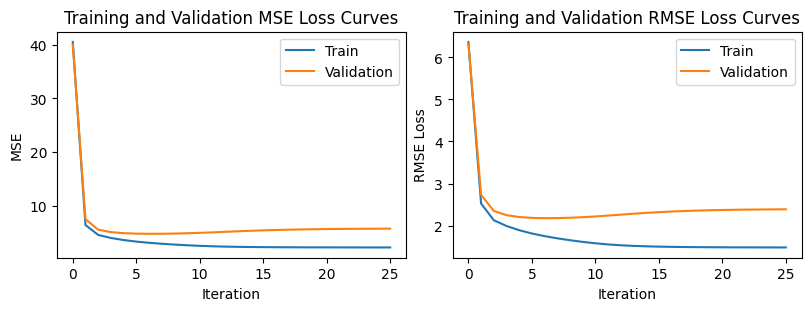

In [18]:
iters = np.arange(len(train_mse_losses))
fig, ax = plt.subplots(1, 2, figsize=(8,3), constrained_layout = True) 
ax[0].plot(iters, train_mse_losses, label='Train')
ax[0].plot(iters, val_mse_losses, label='Validation')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('MSE')
ax[0].set_title('Training and Validation MSE Loss Curves')
ax[0].legend()

ax[1].plot(iters, train_rmse_losses, label='Train')
ax[1].plot(iters, val_rmse_losses, label='Validation')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('RMSE Loss')
ax[1].set_title('Training and Validation RMSE Loss Curves')
ax[1].legend();


# Evaluation

In [19]:
test_edge_index, test_edge_values = test_edge_index.to(device), test_edge_values.to(device)
r_mat_test_edge_values = r_mat_test_edge_values.to(device)

In [20]:
model.eval()
with torch.no_grad():
    pred_rating = model.forward(test_edge_index, test_edge_values)
    test_loss = loss_func(r_mat_test_edge_values.view(-1,1), pred_rating)
    print(f"MSE: {round(test_loss.item(), 5)}, RMSE: {round(test_loss.sqrt().item(), 5)}")

MSE: 5.31336, RMSE: 2.30507
